In [25]:
from transformers import AutoTokenizer
from llmfoundry.utils.builders import build_dataloader
import os
from transformers import PreTrainedTokenizerBase
from composer import DataSpec
from omegaconf import OmegaConf
from omegaconf import OmegaConf, DictConfig
import streaming

In [26]:
def get_data_loader(
    cfg: dict,
    tokenizer: PreTrainedTokenizerBase,
    device_train_batch_size: int,
) -> DataSpec:

    os.environ["S3_ENDPOINT_URL"] = "http://128.232.115.19:9000"

    train_loader = build_dataloader(
        cfg,
        tokenizer,
        device_train_batch_size,
    )
    return train_loader


In [27]:
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B")
# tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token

In [28]:
streaming.base.util.clean_stale_shared_memory()

streams = {
    "name": "text",
    "dataset": {
        "remote": "s3://smollm-corpus/shared/cosmo/client_0",
        "local": "/nfs-share/datasets/photon/dataset_cache/smollm-corpus-shared/cosmo/client_0",
        "split": "train",
        "proportion": "0.10",
        "max_seq_len":2048, 
        "cache_limit": None
    },
    "num_workers": 4,
    "drop_last": True,
}
train_dataloader = get_data_loader(
    streams,
    tokenizer,
    device_train_batch_size=1,
)

In [29]:
sample = next(iter(train_dataloader.dataloader))

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [30]:
print(sample.keys())
print(sample["input_ids"].shape)
print(sample["labels"].shape)
print(sample["total_tokens"])
print(sample["loss_generating_tokens"])


dict_keys(['input_ids', 'labels', 'total_tokens', 'loss_generating_tokens'])
torch.Size([1, 2048])
torch.Size([1, 2048])
[2048]
[tensor(2047)]


In [42]:
import torch

def get_attention_mask_for_packed_sequence(input_ids, eos_token_id):
    """
    Create a causal attention mask for packed sequences.
    Each sequence in the batch should not attend to tokens from other sequences.
    """
    batch_size, seq_len = input_ids.shape
    
    # Create causal mask for each sample in the batch
    attention_masks = []
    
    for batch_idx in range(batch_size):
        x = input_ids[batch_idx]
        T = x.size(0)
        
        # Find EOS token positions
        eos_positions = (x == eos_token_id).nonzero(as_tuple=True)[0]
        
        if len(eos_positions) == 0:
            # No EOS tokens found, treat as single sequence
            mask = torch.tril(torch.ones(T, T, dtype=torch.bool))
        else:
            # Create base causal mask
            mask = torch.tril(torch.ones(T, T, dtype=torch.bool))
            
            # Add sequence boundaries
            sequence_starts = torch.cat([torch.tensor([0]), eos_positions + 1])
            sequence_ends = torch.cat([eos_positions, torch.tensor([T - 1])])
            
            print(sequence_starts, sequence_ends)

            # Mask out attention between different sequences
            for i, (start, end) in enumerate(zip(sequence_starts, sequence_ends)):
                if i < len(sequence_starts) - 1:  # Not the last sequence
                    # Tokens in current sequence shouldn't attend to future sequences
                    mask[start:end+1, end+1:] = False
                    # Tokens in future sequences shouldn't attend to current sequence
                    mask[end+1:, start:end+1] = False
        
        attention_masks.append(mask)
    
    return torch.stack(attention_masks)

def visualize_attention_mask(mask, tokenizer, input_ids, max_display=2048):
    """Helper function to visualize the attention mask"""
    import matplotlib.pyplot as plt
    
    # Only show first max_display tokens for readability
    display_len = min(max_display, mask.shape[-1])
    mask_subset = mask[0, :display_len, :display_len]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(mask_subset.float(), cmap='Blues', aspect='equal')
    
    # Add token labels if provided
    if input_ids is not None:
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0, :display_len])
        ax.set_xticks(range(display_len))
        ax.set_yticks(range(display_len))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax.set_title('Causal Attention Mask for Packed Sequence')
    ax.set_xlabel('Key Positions')
    ax.set_ylabel('Query Positions')
    plt.tight_layout()
    plt.show()
    
def visualize_position_mask(mask, max_display=2048):
    """Helper function to visualize the attention mask"""
    import matplotlib.pyplot as plt
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(mask[0].float())
    
    plt.tight_layout()
    plt.show()
    
def generate_source_len_mask(attention_mask):
        """Generate source length mask with position indices for each sequence."""
        batch_size, seq_len, _ = attention_mask.shape

        # Initialize position mask
        position_mask = torch.zeros(
            batch_size, seq_len, dtype=torch.long, device=attention_mask.device
        )

        for batch_idx in range(batch_size):
            mask = attention_mask[batch_idx]

            # Find where attention is allowed (causal mask pattern)
            # For each position, count how many previous positions it can attend to
            for pos in range(seq_len):
                # Count valid positions this token can attend to (including itself)
                valid_positions = mask[pos, : pos + 1].sum().item()
                position_mask[batch_idx, pos] = (
                    valid_positions - 1
                )  # 0-indexed positions
        torch.set_printoptions(profile="full")
        print(position_mask)
        torch.set_printoptions(profile="default")
        
        return position_mask

Tokenizer Special Tokens:
BOS token: <|endoftext|> (ID: 0)
EOS token: <|endoftext|> (ID: 0)
PAD token: None
UNK token: <|endoftext|> (ID: 0)

Sample input_ids shape: torch.Size([1, 2048])
First sequence EOS positions: tensor([   0,    1,  717,  718,  719,  720, 1438, 1439, 1440, 1441])
tensor([   0,    1,    2,  718,  719,  720,  721, 1439, 1440, 1441, 1442]) tensor([   0,    1,  717,  718,  719,  720, 1438, 1439, 1440, 1441, 2047])
tensor([[  0,   0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
          54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
          68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
          82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
          

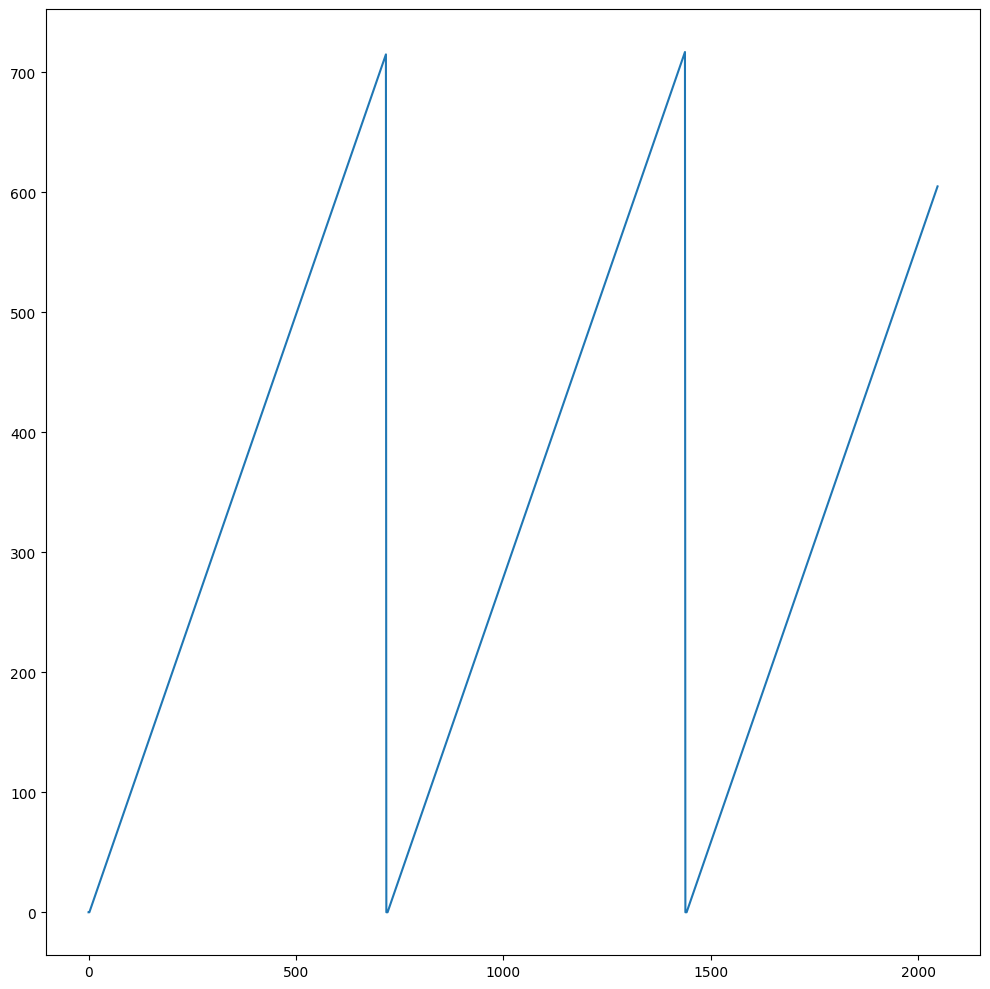

In [43]:
# Test the tokenizer special tokens
print("Tokenizer Special Tokens:")
print(f"BOS token: {tokenizer.bos_token} (ID: {tokenizer.bos_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")
print(f"PAD token: {tokenizer.pad_token}")
print(f"UNK token: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

print(f"\nSample input_ids shape: {sample['input_ids'].shape}")
print(f"First sequence EOS positions: {torch.where(sample['input_ids'][0] == tokenizer.eos_token_id)[0]}")

# Generate attention mask for the sample
attention_mask = get_attention_mask_for_packed_sequence(sample["input_ids"][:1], tokenizer.eos_token_id)
pos_mask = generate_source_len_mask(attention_mask)
print(f"\nAttention mask shape: {attention_mask.shape}")

# Decode and show first sequence for context
first_sequence = sample["input_ids"][0]
decoded_text = tokenizer.decode(first_sequence)  # First 100 tokens
print(f"\nFirst 100 tokens decoded: {decoded_text[:200]}...")

# Visualize the attention mask
# visualize_attention_mask(attention_mask, tokenizer, sample["input_ids"][:1])
visualize_position_mask(pos_mask)


In [33]:
# Test with a simpler example to verify correctness
def test_packed_sequence_mask():
    """Test the mask function with a known packed sequence"""
    
    # Create a simple test case with known sequences
    # Sequence 1: [1, 2, 3, EOS] Sequence 2: [4, 5, EOS] Sequence 3: [6, 7, 8, EOS]
    test_input = torch.tensor([[1, 2, 3, tokenizer.eos_token_id, 4, 5, tokenizer.eos_token_id, 6, 7, 8, tokenizer.eos_token_id, 0, 0, 0, 0]])
    
    mask = get_attention_mask_for_packed_sequence(test_input, tokenizer)
    
    print("Test input shape:", test_input.shape)
    print("Test mask shape:", mask.shape)
    print("Test input:", test_input[0])
    print("EOS positions:", torch.where(test_input[0] == tokenizer.eos_token_id)[0])
    
    # Check specific positions
    print("\nMask verification:")
    print("Token 2 can attend to token 0 (same seq):", mask[0, 2, 0].item())
    print("Token 2 cannot attend to token 4 (diff seq):", not mask[0, 2, 4].item())
    print("Token 5 can attend to token 4 (same seq):", mask[0, 5, 4].item())
    print("Token 5 cannot attend to token 0 (diff seq):", not mask[0, 5, 0].item())
    
    return mask

test_mask = test_packed_sequence_mask()

AttributeError: 'bool' object has no attribute 'nonzero'